### Starbucks Capstone Project

# Part II. Data Processing & Modelling

**This notebook is Part II of Starbucks Capstone Project**

3. Methodology
    - Data Preprocessing
    - Modelling
    - Refinement
4. Results
    - Model Evaluation and Validation
    - Conclusion   

## 3.1 Data Preprocessing
Now we've explored the data, we will try to combine related data together.


**First Imports**

In [5]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


#Imputation 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

**Portfolio Dataset**
We merge portfolio data with transcript data. There is only one thing to handle before move on.
We will drop the informational offers because we they can not labelled as "offer completed".

In [6]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


We will drop 'informational' offers because we will only evaluate the offers completed.

In [7]:
portfolio_df = portfolio.drop([2,7])

Then we will encode the channels for further use

In [8]:
def enc_channels(df):
    '''
        Takes a dataframe as input, encode the channels column.
        '''
    
    #channels column(excluded 'email', because it exists in all entries)
    channels = ['web', 'mobile', 'social']

    for channel in channels:
        df[channel] = df.channels.apply(lambda x: channel in x)*1

    #drop channels column
    df = df.drop('channels', axis=1)
    
    return df
portfolio_enc = enc_channels(portfolio_df)

In [9]:
portfolio_enc.head()

,reward,difficulty,duration,offer_type,id,web,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1


**Profile dataset**:

**Next we handle missing values in Profile data**
as we see in the first part there are 2175 profiles that gender and income are missing and age is 118.
I will use this data because these profiles are also a cluster in segmentation.
   * I will change missing gender as "U".
    * I will change income and age with mean because their distributions are seems as normal.

In [10]:
#Replace 118 with Nan for further imputation.
profile['age'] = profile['age'].replace(118, np.nan)

In [11]:
#Fill nan values with a new gender group 'U'
profile.gender.fillna(value='U', inplace=True)

We will use an iterative imputer against imputing mean for better distribution, 
Iterative imputer over missing values in'income' and 'age' datas.

In [12]:
imputed_features = profile.copy()

col_names = ['income', 'age']
impute_columns = imputed_features[col_names]

# Use scaler of choice; here Standard scaler is used
imputer = IterativeImputer(random_state=0).fit(impute_columns.values)
impute_columns = imputer.transform(impute_columns.values)

imputed_features[col_names] = impute_columns

In [13]:
#Round imputed features
imputed_features = imputed_features.round()
#Rename 'id' column as 'person' to merge with transaction
imputed_features = imputed_features.rename(columns={'id': 'person'})
imputed_features.head()

,gender,age,person,became_member_on,income
0,U,54.0,68be06ca386d4c31939f3a4f0e3dd783,20170212,65405.0
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,U,54.0,38fe809add3b4fcf9315a9694bb96ff5,20180712,65405.0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,U,54.0,a03223e636434f42ac4c3df47e8bac43,20170804,65405.0


**After we handle missing values we will try to convert "became_member_on" to member total days in order to use in model.**

In [14]:
imputed_features['became_member_on'] = pd.to_datetime(imputed_features['became_member_on'], format='%Y%m%d')
last_date_df = imputed_features.sort_values(by='became_member_on')
last_date = last_date_df['became_member_on'].iloc[-1]

In [15]:
imputed_features['days_member'] =  (last_date - imputed_features['became_member_on']).dt.days
imputed_features.head()

,gender,age,person,became_member_on,income,days_member
0,U,54.0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,65405.0,529
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,376
2,U,54.0,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,65405.0,14
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,443
4,U,54.0,a03223e636434f42ac4c3df47e8bac43,2017-08-04,65405.0,356


**Transcript Data set**

Now we will handle transcript data

In [16]:
def encode_offer_id(x):
    try :
        return x['offer id']
    except:
        return x['offer_id']

def transcript_encoded(transcript_df):
    '''
        Takes transcript dataframe, get a copy, encode 'offer_id' column,
        create 'amount' and 'reward' columns from dictionary keys.
        '''
   
    
    transcript_encoded = transcript_df.copy()
    transcript_encoded['offer_id'] = transcript[transcript.event.isin(
        ['offer received', 'offer viewed', 'offer completed'])].value.apply(encode_offer_id)
    transcript_encoded['amount'] = transcript_encoded['value'].apply(lambda x: x.get('amount'))
    transcript_encoded['reward'] = transcript_encoded['value'].apply(lambda x: x.get('reward'))
    transcript_encoded = transcript_encoded.drop(columns='value')
    return transcript_encoded

df_encoded=transcript_encoded(transcript)

In [17]:
df_encoded.head()

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [18]:
df_encoded_event = df_encoded[df_encoded.event != 'transaction'].drop(columns='amount')
df_event_count = pd.get_dummies(df_encoded_event, columns=['event'])
df_event_count.shape

(167581, 7)

In [19]:
df_event_count.head()

,person,time,offer_id,reward,event_offer completed,event_offer received,event_offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0


In [20]:
col_list = ['event_offer completed','event_offer received', 'event_offer viewed']
transaction_df=df_event_count.groupby(['person', 'offer_id'])[col_list].max().reset_index()
transaction_df = transaction_df.rename(columns={'offer_id': 'id', 
                                                'event_offer completed' : 'completed',
                                                'event_offer received': 'received',
                                                'event_offer viewed': 'viewed'})
transaction_df.head()

,person,id,completed,received,viewed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1


**Merge transaction with portfolio**

In [21]:
df = transaction_df.merge(portfolio_enc, on = 'id')
df.head()

,person,id,completed,received,viewed,reward,difficulty,duration,offer_type,web,mobile,social
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,2,10,7,discount,1,1,0
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,0,1,0,2,10,7,discount,1,1,0
2,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,0,1,0,2,10,7,discount,1,1,0
3,0069a50874d846438e58acff5e594725,2906b810c7d4411798c6938adc9daaa5,1,1,1,2,10,7,discount,1,1,0
4,00715b6e55c3431cb56ff7307eb19675,2906b810c7d4411798c6938adc9daaa5,1,1,1,2,10,7,discount,1,1,0


**Merge with profile dataset**

In [22]:
df_full = df.merge(imputed_features, on ='person')
df_full.head()

,person,id,completed,received,viewed,reward,difficulty,duration,offer_type,web,mobile,social,gender,age,became_member_on,income,days_member
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,2,10,7,discount,1,1,0,M,33.0,2017-04-21,72000.0,461
1,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,5,5,5,bogo,1,1,1,M,33.0,2017-04-21,72000.0,461
2,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,2,10,10,discount,1,1,1,M,33.0,2017-04-21,72000.0,461
3,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,0,1,0,2,10,7,discount,1,1,0,F,19.0,2016-08-09,65000.0,716
4,00426fe3ffde4c6b9cb9ad6d077a13ea,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,2,10,10,discount,1,1,1,F,19.0,2016-08-09,65000.0,716


<AxesSubplot:xlabel='completed', ylabel='count'>

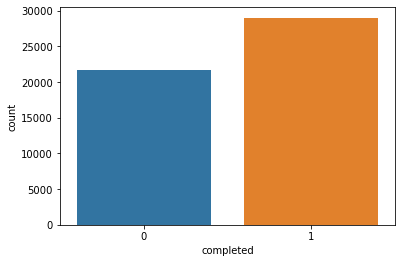

In [23]:
sns.countplot(x='completed', data=df_full)

There is a slight class imbalance

Before move onto modelling remove:
- 'person'and'id' we wont use ids for classification
- 'became_member_on' we will use total days of membership
- 'received' because basicaly all entries are 1.

In [24]:
list1 = ['person','id','became_member_on','received']
list2 = ['offer_type', 'gender','difficulty', 'duration', 'reward']
new_df = df_full.drop(list1, axis=1)
new_df.head()

,completed,viewed,reward,difficulty,duration,offer_type,web,mobile,social,gender,age,income,days_member
0,1,0,2,10,7,discount,1,1,0,M,33.0,72000.0,461
1,1,1,5,5,5,bogo,1,1,1,M,33.0,72000.0,461
2,1,1,2,10,10,discount,1,1,1,M,33.0,72000.0,461
3,0,0,2,10,7,discount,1,1,0,F,19.0,65000.0,716
4,1,1,2,10,10,discount,1,1,1,F,19.0,65000.0,716


**Dealing with categorical variables**

In [25]:
df_model = pd.get_dummies(new_df, columns=list2)
df_model.head()

,completed,viewed,web,mobile,social,age,income,days_member,offer_type_bogo,offer_type_discount,...,difficulty_7,difficulty_10,difficulty_20,duration_5,duration_7,duration_10,reward_2,reward_3,reward_5,reward_10
0,1,0,1,1,0,33.0,72000.0,461,0,1,...,0,1,0,0,1,0,1,0,0,0
1,1,1,1,1,1,33.0,72000.0,461,1,0,...,0,0,0,1,0,0,0,0,1,0
2,1,1,1,1,1,33.0,72000.0,461,0,1,...,0,1,0,0,0,1,1,0,0,0
3,0,0,1,1,0,19.0,65000.0,716,0,1,...,0,1,0,0,1,0,1,0,0,0
4,1,1,1,1,1,19.0,65000.0,716,0,1,...,0,1,0,0,0,1,1,0,0,0


In [26]:
df_model.shape

(50637, 25)

## 3.2 Modelling

- First we import sklearn's library for data preprocessing and modelling
- Then we load data and scale age, income and days_member columns, because some of the algorithms do not auto scale
- Train test split and then we apply feature selection
- we run 3 different models, Linear Svc,SVC and RandomForest Classifier and compare accuracy
- we will run GridsearchCV
- we will fine tune with ROC curve

**Imports**

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


**Load Data**

In [28]:
def form_data(df):
    
    """ Forms data from model dataframe
     Create arrays for inputs, labels. 
    
    Arg:
        df: pandas dataframe
    Returns:
        X : Input Array
        y : Labels(output) Array
    
    """
    X = df.iloc[:, 1:]
    y = df.iloc[:, 0]
        
    return X, y
    
X, y = form_data(df_model)
X.shape

(50637, 24)

**Feature Selection** 

In [29]:
X_new = SelectKBest(chi2, k=15).fit_transform(X, y)

**Train-test split**

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state = 42)

**LinearSVC**

Create a pipeline :
* scaler
* linearSVC

In [31]:
linear_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()), 
    ('lnr_svc', LinearSVC(dual=False))])

Fit model

In [32]:
linear_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lnr_svc', LinearSVC(dual=False))])

get accuracy score

In [33]:
y_hat_train = linear_pipe.predict(X_train)
accuracy_score(y_train, y_hat_train)

0.7274185983361722

0.72 accuracy seems better than nothing we will try other models

**SVC**
Train a model with polynomial kernel.

In [34]:
kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC())])
kernel_svm_clf.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svm_clf', SVC())])

In [35]:
svm_train = kernel_svm_clf.predict(X_train)
accuracy_score(y_train, svm_train)

0.7461304895208473

Slightly better than linear kernel,
run a cross validation for better test results

In [36]:
cross_val_score(kernel_svm_clf, X_train, y_train, cv=5,
scoring="accuracy")

array([0.75030857, 0.74166872, 0.74006418, 0.74216243, 0.74176028])

Performs similar on the folds, we will then try one last model

**RandomForest Classifier**

In [37]:
rnd_forest = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                     n_jobs=-1, oob_score=True, random_state=42)
rnd_forest.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, oob_score=True,
                       random_state=42)

In [39]:
forest_pred=rnd_forest.predict(X_train)
accuracy_score(y_train, forest_pred)

0.9941988200153052

.99 accuracy seems very well, but before fixing that we should see performance in folds, because there will be overfitting

In [40]:
cross_val_score(rnd_forest, X_train, y_train, cv=3,
scoring="accuracy")

array([0.72132119, 0.72672739, 0.72065467])

we will run a gridsearch on below paramters on 3 folds and also use roc auc score

In [41]:
param_grid = {
    
    'n_estimators': [100,  1000],
    'max_depth' : [8, 10]}
    

forest_clf = RandomForestClassifier(class_weight = 'balanced',random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(rnd_forest,param_grid, cv=3,
                           scoring='roc_auc',
                           return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, oob_score=True,
                                              random_state=42),
             param_grid={'max_depth': [8, 10], 'n_estimators': [100, 1000]},
             return_train_score=True, scoring='roc_auc')

In [42]:
grid_search.cv_results_

{'mean_fit_time': array([0.67360401, 5.37062502, 0.73555923, 6.08757798]),
 'std_fit_time': array([0.07672029, 0.1762138 , 0.03468782, 0.22182566]),
 'mean_score_time': array([0.04101745, 0.38635747, 0.04490169, 0.3957804 ]),
 'std_score_time': array([0.00045504, 0.02617929, 0.00082573, 0.00884251]),
 'param_max_depth': masked_array(data=[8, 8, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[100, 1000, 100, 1000],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 8, 'n_estimators': 100},
  {'max_depth': 8, 'n_estimators': 1000},
  {'max_depth': 10, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 1000}],
 'split0_test_score': array([0.83179965, 0.83165356, 0.83057253, 0.83139624]),
 'split1_test_score': array([0.8316241 , 0.83125098, 0.83163355, 0.83231888]),
 'split2_test_score': array([0.82900285,

In [43]:
grid_search.best_params_

{'max_depth': 10, 'n_estimators': 1000}

best parameters gathered from search has :
mean roc_auc score on validation : .83
mean roc_auc score on train : .87

there is a slight overfitting but we will save this model.

In [44]:
import joblib

In [45]:
joblib_file = "forest_clf.pkl"
joblib.dump(grid_search, joblib_file)

['forest_clf.pkl']

I will evaluate the confusion matrix

In [46]:
grid_pred = grid_search.predict(X_train)
cm = confusion_matrix(y_train, grid_pred)
cm

array([[13562,  3757],
       [ 4997, 18193]])

<AxesSubplot:>

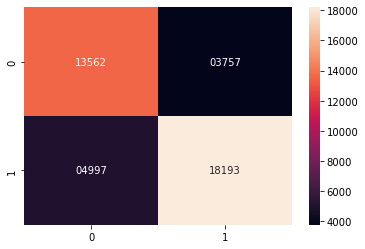

In [47]:
sns.heatmap(cm, annot= True, fmt = '0>5')

Finally draw a roc curve

In [48]:
y_probs = grid_search.predict_proba(X_train) 
y_scores = y_probs[:, 1] # score = proba of positive class
fpr, tpr, thresholds_forest = roc_curve(y_train,y_scores)

In [49]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

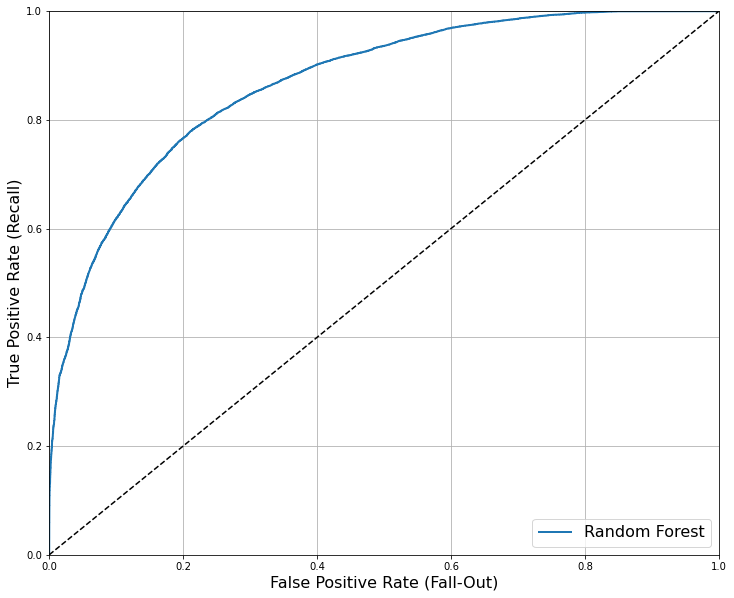

In [55]:

plt.figure(figsize=(12, 10))
plot_roc_curve(fpr, tpr, "Random Forest")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

and finally we run our model on test set

In [51]:
grid_search.fit(X_test, y_test)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, oob_score=True,
                                              random_state=42),
             param_grid={'max_depth': [8, 10], 'n_estimators': [100, 1000]},
             return_train_score=True, scoring='roc_auc')

In [52]:
y_testprobs = grid_search.predict_proba(X_test) 
y_testscores = y_testprobs[:, 1] # score = proba of positive class
fpr_test, tpr_test, thresholds_test = roc_curve(y_test,y_testscores)

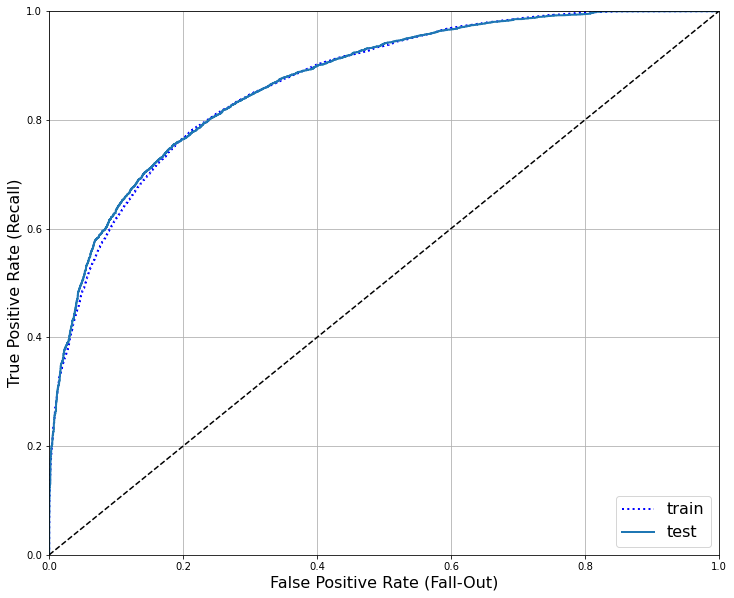

In [54]:
plt.figure(figsize=(12, 10))
plt.plot(fpr, tpr, "b:", linewidth=2, label="train")
plot_roc_curve(fpr_test, tpr_test, "test")

plt.grid(True)
plt.legend(loc="lower right", fontsize=16)

plt.show()